###  Example of the coherence computation

In this notebook we use the autoregressive example model from [Dhamala et. al.](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.100.018701). The model consists of two coupled random variables ($2\rightarrow 1$), the coupling is time-varying therefore the coherence should detect the coupling dynamics. The model is given by the equations bellow:

$X_{1}(t) = 0.55X_{1}(t-1)-0.8X_{1}(t-2)+C(t)X_{2}(t-1)+\epsilon (t)$

$X_{2}(t) = 0.55X_{2}(t-1)-0.8X_{2}(t-2)+\xi (t)$

Here, $X_1(t)$ and $X_2(t)$ are $AR(2)$. The variable $t$ is the time step index,
such that the actual time is $t'=t\,\Delta t=t/f_{\rm s}$. Besides, we know by construction that
$X_2(t)$ influences $X_1(t)$ through the coupling constant $C$
(although the opposite does not happen). In the simulation $C(t)=0.25$ for $t<15$ s, and zero otherwise. 

In [1]:
import sys
sys.path.insert(1, '/home/vinicius/storage1/projects/GrayData-Analysis')

import time
import scipy
import h5py
import numpy                 as     np
import xarray                as     xr
import pandas                as     pd
import matplotlib.pyplot     as     plt
from   tqdm                  import tqdm
from   xfrites.conn.conn_coh import conn_coherence_wav

#### Defining function to simulate de model

In [2]:
def ar_model_dhamala(N=5000, Trials = 10, Fs = 200, C=0.2, t_start=0, t_stop=None, cov = None):
    ''' 
        AR model from Dhamala et. al.
    '''
    
    T = N / Fs

    time = np.linspace(0, T, N)

    X = np.random.random([Trials, N]) 
    Y = np.random.random([Trials, N]) 

    def interval(t, t_start, t_stop):
        if t_stop==None:
            return (t>=t_start)
        else:
            return (t>=t_start)*(t<=t_stop)

    for i in tqdm( range(Trials) ):
        E = np.random.multivariate_normal(np.zeros(cov.shape[0]), cov, size=(N,))
        for t in range(2, N): 
            X[i,t] = 0.55*X[i,t-1] - 0.8*X[i,t-2] + interval(time[t],t_start,t_stop)*C*Y[i,t-1] + E[t,0]
            Y[i,t] = 0.55*Y[i,t-1] - 0.8*Y[i,t-2] + E[t,1]

    Z = np.zeros([Trials,2,N]) 

    Z[:,0,:] = X 
    Z[:,1,:] = Y 

    return Z

Model parameters

In [3]:
N  = 5000      # Number of observations
Fs = 200       # Sampling frequency
dt = 1.0 / Fs  # Time resolution
C  = 0.25      # Coupling parameter
Trials = 100   # Number of trials
freqs  = np.arange(1,100,1) # Frequency axis
# Covariance matrix
cov = np.array([ [1.00, 0.00],
                 [0.00, 1.00] ])

Generating data

In [4]:
# Generating data
X = ar_model_dhamala(N=N, Trials = Trials, C=C, Fs=Fs, t_start=0, t_stop=15, cov=cov)

100%|██████████| 100/100 [00:02<00:00, 39.17it/s]


In [5]:
X = xr.DataArray(X, dims=('trials', 'roi', 'times'),
                 coords=(np.arange(Trials), ['r0', 'r1'], np.arange(N) / Fs))

### Measuring coherence

To compute the coherence first the cross ($S_{12}(f,t)$), and auto-spectogram ($S_{11}(f,t)$ and $S_{22}(f,t)$) are computed. The coherence is defined as:

$C_{12}(f,t) = \frac{S_{12}S_{12}^{*}}{S_{11}S_{22}}$

However, for the equation above $C_{12}(f,t)=1$ $\forall \text{  } f, \text{ and } t$. Therefore, before taking the ratio in the equation above some temporal and frequency smoothing should be done. To do this, we convolve the auto- and cross-spectogram with a square window of size $w_f$, and $w_rt$, for the frequency and time axis, respectively.

Let's $g(w_t,w_f)$ be the filter, and $\tilde{g}(w_t,w_f)$ its representation in the frequency domain. We can then convolve each spectra with $g$, which gives:

$C_{12}(f,t) = \frac{\tilde{g}*(S_{12}S_{12}^{*})}{\tilde{g}*(S_{11})\tilde{g}*(S_{22})}$

Note that we ommit the dependencies on $f$ and $t$ for the spectra, and on $w_t$ and $w_f$ for the filter.

In [6]:
start = time.time()

# define temporal windows + compute the DFC
n_cycles = freqs / 2.

kw = dict(
    freqs=freqs, times=None, roi=None, foi=None, n_jobs=-1,
    sfreq=Fs, mode='multitaper', n_cycles=n_cycles, decim=15,
    sm_times=300, sm_freqs=1, block_size=2
)

# compute the coherence
coh = conn_coherence_wav(X.values.astype(np.float32), **kw).astype(np.float32)

end = time.time()

print('Elapsed time to load super-tensor: ' +str((end - start)) + ' sec.' )

WARNING | No time vector. A default one is created
WARNING | No regions of interest are provided (roi). Default ones are created
Compute pairwise coherence (n_pairs=1, n_freqs=99, decim=15)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    5.9s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    5.9s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    6.2s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

Elapsed time to load super-tensor: 24.958765506744385 sec.


Text(0.5, 1.0, 'Coherence')

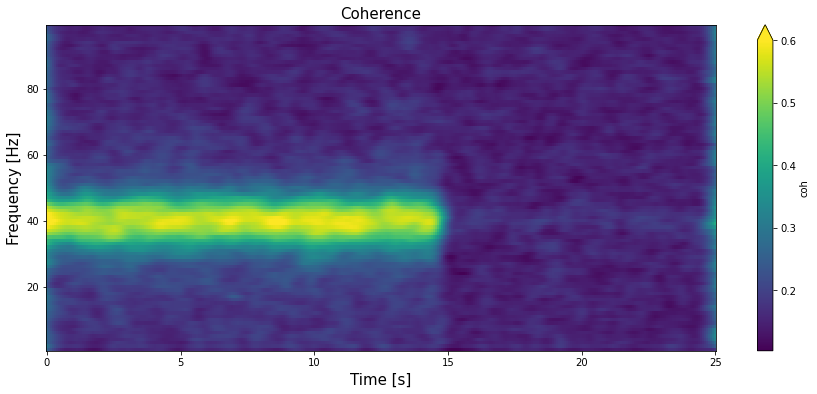

In [7]:
plt.figure(figsize=(15,6))
coh.isel(roi=0).mean(dim="trials").plot.imshow(x="times", y="freqs", vmax=.6)
plt.ylabel('Frequency [Hz]', fontsize=15)
plt.xlabel('Time [s]', fontsize=15)
plt.title('Coherence', fontsize=15)

### How parameters influences

Next we analyse how the temporal and frequency smoothing influences the coherence computation. The other parameters such as down-sampling factor ($\Delta$) and number of cycles ($\lambda$) are maintained fixed: $\Delta = 15$ and $\lambda = f_c/2$, where $f_c$ are the center frequencies used.

One important thing to note is: what is the duration of the smoothing window in time?

If $f_s$ is the original sampling frequency of the signal, with a down-sampling factor of $\Delta$, and the time-smoothing window of $w_t$ is given in bins, its respective time-length is simply:

$w_t^{'} = w_t \Delta/f_s$

To demonstrate the influence of the dimensions of the filter $g$ in the coherence estimation we will use the combination of the following values for $w_t$ and $w_f$, respectively: $w_t=\{1, 10, 30, 70\}$, $w_t=\{1, 3, 5\}$. Notice that we use the values of $w_t$ and $w_f$ in bins but their respective length in time can be obtained using 
the equation above.

Below we show the results for the Morlet and Multitaper methods, respectively.

In [8]:
win_time = [1, 100, 300, 500]

#### Smoothing window in time

WARNING | No time vector. A default one is created
WARNING | No regions of interest are provided (roi). Default ones are created
Compute pairwise coherence (n_pairs=1, n_freqs=99, decim=15)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    6.2s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    6.2s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

WARNING | No time vector. A default one is created
WARNING | No regions of interest are provided (roi). Default ones are created
Compute pairwise coherence (n_pairs=1, n_freqs=99, decim=15)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    6.6s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    6.6s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    6.3s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

WARNING | No time vector. A default one is created
WARNING | No regions of interest are provided (roi). Default ones are created
Compute pairwise coherence (n_pairs=1, n_freqs=99, decim=15)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    6.3s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    6.2s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

WARNING | No time vector. A default one is created
WARNING | No regions of interest are provided (roi). Default ones are created
Compute pairwise coherence (n_pairs=1, n_freqs=99, decim=15)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    6.5s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    6.2s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

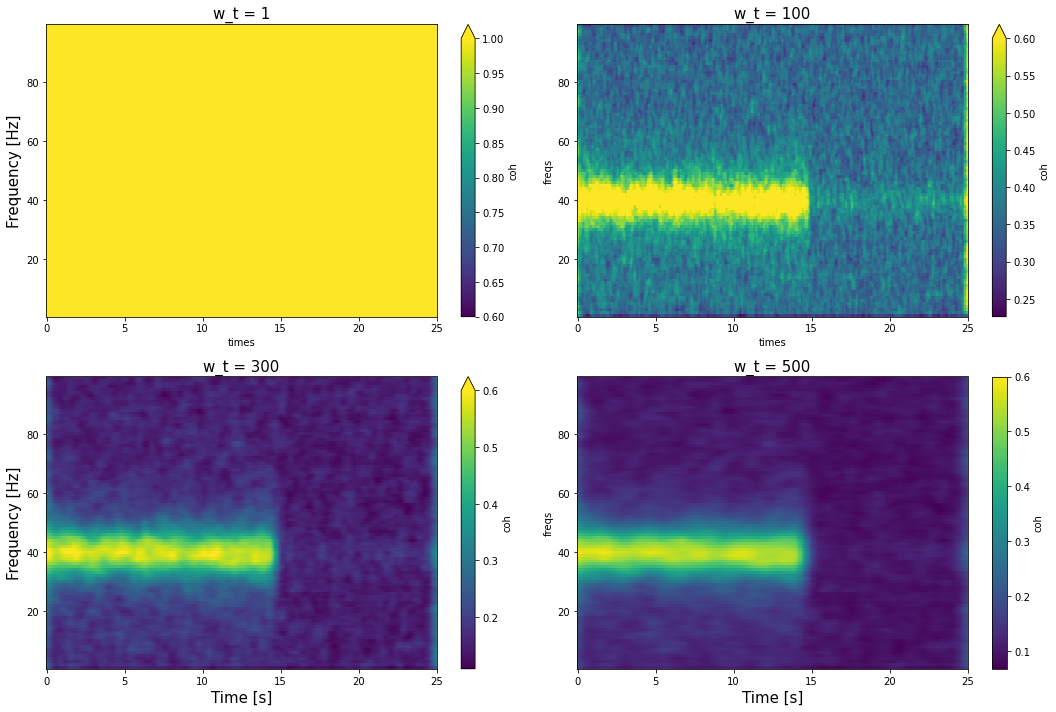

In [9]:
plt.figure(figsize=(15,10))
count = 1
for i in range(len(win_time)):
    kw['sm_times'] = win_time[i]
    coh = conn_coherence_wav(X.values.astype(np.float32), **kw)
    plt.subplot(2, 2, count)
    coh.isel(roi=0).mean(dim="trials").plot.imshow(x="times", y="freqs", vmax=.6)
    if i%2==0: plt.ylabel('Frequency [Hz]', fontsize=15)
    if i==2 or i==3: plt.xlabel('Time [s]', fontsize=15)
    plt.title('w_t = ' + str(win_time[i]), fontsize=15)
    count += 1
plt.tight_layout()
plt.savefig('img/coh_test_morlet.pdf', dpi = 600)

#### Time bandwidth

In [9]:
tb             = np.arange(2,10)
kw['sm_times'] = 300 # Fixing temporal smoothing

In [10]:
plt.figure(figsize=(15,10))
count = 1
for i in range(len(tb)):
    kw['mt_bandwidth'] = tb[i]
    coh = conn_coherence_wav(X.values.astype(np.float32), **kw)
    plt.subplot(2,4,count)
    coh.isel(roi=0).mean(dim="trials").plot.imshow(x="times", y="freqs", vmax=.6)
    if i%2==0: plt.ylabel('Frequency [Hz]', fontsize=15)
    if i==2 or i==3: plt.xlabel('Time [s]', fontsize=15)
    plt.title('time_bandwidth = ' + str(tb[i]), fontsize=15)
    count += 1
plt.tight_layout()
plt.savefig('img/coh_test_morlet.pdf', dpi = 600)

WARNING | No time vector. A default one is created
WARNING | No regions of interest are provided (roi). Default ones are created
Compute pairwise coherence (n_pairs=1, n_freqs=99, decim=15)


UnboundLocalError: local variable 'out' referenced before assignment

<Figure size 1080x720 with 0 Axes>

### Estimating coherence for broadbands using Multitaper method

To estimate the coherence (or spectra) in given bands we can use the multitaper method. Supose that we have the center frequencies of each band $f_c = \{f_{0},\dots, f_{n}\}$, where $n$ is the number of bands, and the bandwidth of each band $\delta f = \{\delta f_{0},\dots,\delta f_{n}\}$.

If $t_b$ is the time bandwidth of the Multitaper transform, the number of cycles can be computed by:

$n_\rm{cycles} = t_b\frac{f_c}{\delta f}$

This can be used to compute the spctra (and the coherence) directly in each band of interest.

For this example using the toy model, let's supose that:

$f_c = \{12.5, 37.5, 62.5, 87.5\}$, and

 $\delta f = \{12.5, 12.5, 12.5, 12.5\}$
 
 If we set $t_b = 8.0$, the number of cycles will be $n_\rm{cycles} = 8.0\frac{f_c}{12.5} =\{8, 24, 40, 56\}$

In [12]:
bands = ['0-25Hz','25-50Hz', '50-75Hz','75-100Hz']
f_c = np.array([12.5,37.5,62.5,87.5])
d_f = np.ones_like(f_c) * 12.5
t_b = 4.0
n_cycles = t_b * f_c / d_f

WARNING | No time vector. A default one is created
WARNING | No regions of interest are provided (roi). Default ones are created
Compute pairwise coherence (n_pairs=1, n_freqs=4, decim=15)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    1.2s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    1.2s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

WARNING | No time vector. A default one is created
WARNING | No regions of interest are provided (roi). Default ones are created
Compute pairwise coherence (n_pairs=1, n_freqs=4, decim=15)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    1.3s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    1.3s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

WARNING | No time vector. A default one is created
WARNING | No regions of interest are provided (roi). Default ones are created
Compute pairwise coherence (n_pairs=1, n_freqs=4, decim=15)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    1.3s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    1.3s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

WARNING | No time vector. A default one is created
WARNING | No regions of interest are provided (roi). Default ones are created
Compute pairwise coherence (n_pairs=1, n_freqs=4, decim=15)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    1.3s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    1.3s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

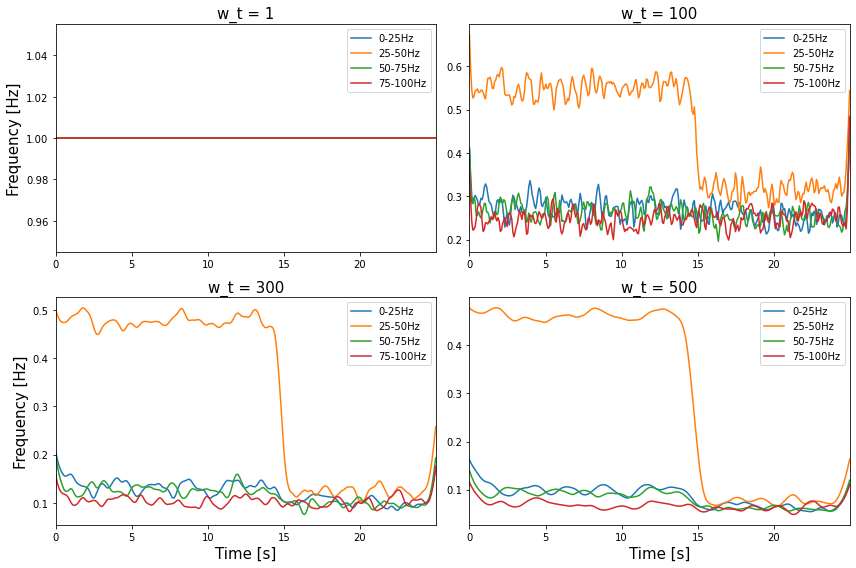

In [13]:
plt.figure(figsize=(12,8))
count = 1

kw['freqs']        = f_c

for i in range(len(win_time)):
    kw['n_cycles']     = n_cycles
    kw['sm_times']     = win_time[i]
    kw['mt_bandwidth'] = t_b
    
    coh = conn_coherence_wav(X.values.astype(np.float32), **kw)

    plt.subplot(2,2,count)
    for b in range(len(f_c)):
        plt.plot(coh.times, coh.isel(roi=0).mean(dim='trials')[b,:], label = bands[b])
        if i%2==0: plt.ylabel('Frequency [Hz]', fontsize=15)
        if i==2 or i==3: plt.xlabel('Time [s]', fontsize=15)
        plt.title('w_t = ' + str(win_time[i]), fontsize=15)
        plt.legend()
        plt.xlim(coh.times[0],coh.times[-1])
    count += 1
plt.tight_layout()
plt.savefig('coh_bands_multitaper.pdf', dpi = 600)

As expected using $w_f>1$ is not good because it averages over bands creating artificial peaks. And big values of $w_t$ results in poor temporal resolution of events, for instance for $w_t=70$ the moment when the coupling between $X_1(t)$ and $X_2(t)$ is turned off is not well located in time.

### Single-trial coherence estimation using Multitaper method

For this example we will set $w_t = 10$ and $w_f=1$ based on the results in the plot above.

In [23]:
w_t = 300

In [24]:
kw['sm_times']     = 300

coh = conn_coherence_wav(X.values.astype(np.float32), **kw)

WARNING | No time vector. A default one is created
WARNING | No regions of interest are provided (roi). Default ones are created
Compute pairwise coherence (n_pairs=1, n_freqs=4, decim=15)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    1.3s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    1.4s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

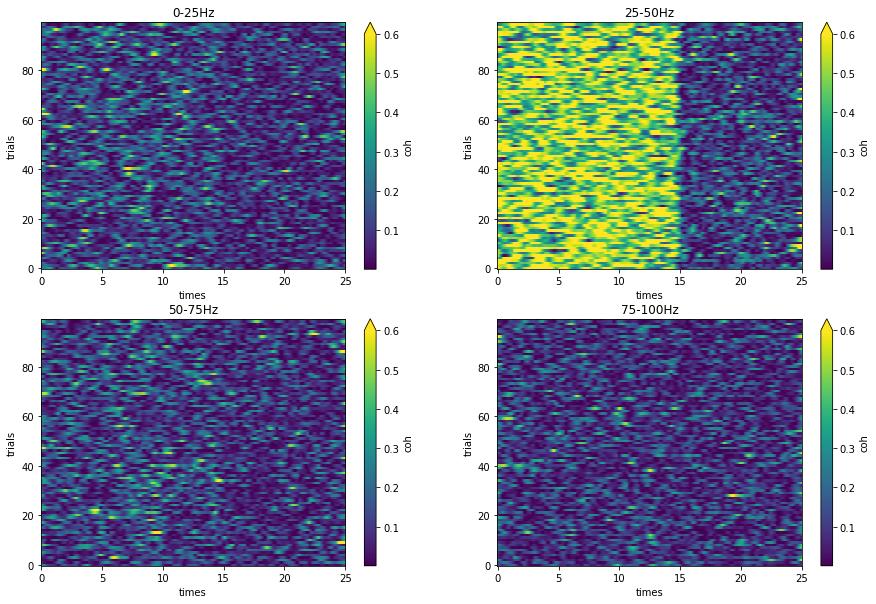

In [29]:
plt.figure(figsize=(15,10))
for i in range(len(f_c)):
    plt.subplot(2,2,i+1)
    coh.isel(roi=0, freqs=i).plot.imshow(x="times", y="trials", vmax=.6)
    #if i==0 or i==2: plt.ylabel('trial number', fontsize=15)
    #if i==2 or i == 3: plt.xlabel('time [s]', fontsize=15)
    plt.title(bands[i])

### Surrogates

In [9]:
from GDa.signal.surrogates import phase_rand_surrogates

In [10]:
def _surrogate_coh(n_surr,val):
    
    # define temporal windows + compute the DFC
    n_cycles = freqs / 2.

    seeds = np.arange(n_surr, dtype=int) * 100
    
    kw = dict(
        freqs=freqs, times=None, roi=None, foi=None, n_jobs=-1,
        sfreq=Fs, mode='multitaper', n_cycles=n_cycles, decim=15,
        sm_times=300, sm_freqs=1, block_size=2, verbose=False,
    )
    
    coh = []
    for seed in tqdm( seeds ):
        X_rnd = phase_rand_surrogates(X,val=val,seed=seed,verbose=False)
        coh  += [conn_coherence_wav(X_rnd.values.astype(np.float32), **kw).astype(np.float32)]
    return xr.concat(coh, "seeds")

In [11]:
coh_surr = _surrogate_coh(10,1)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          |  : 0/100 [00:00<?,       ?it/s]

WARNING | No time vector. A default one is created
WARNING | No regions of interest are provided (roi). Default ones are created
Compute pairwise coherence (n_pairs=1, n_freqs=99, decim=15)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    5.9s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    5.9s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    6.1s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    6.1s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

 10%|█         | 1/10 [00:26<03:54, 26.09s/it]

  0%|          |  : 0/100 [00:00<?,       ?it/s]

WARNING | No time vector. A default one is created
WARNING | No regions of interest are provided (roi). Default ones are created
Compute pairwise coherence (n_pairs=1, n_freqs=99, decim=15)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    6.4s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    6.0s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    6.0s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

 20%|██        | 2/10 [00:52<03:30, 26.36s/it]

  0%|          |  : 0/100 [00:00<?,       ?it/s]

WARNING | No time vector. A default one is created
WARNING | No regions of interest are provided (roi). Default ones are created
Compute pairwise coherence (n_pairs=1, n_freqs=99, decim=15)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    6.2s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    6.0s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    6.0s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

 30%|███       | 3/10 [01:19<03:05, 26.48s/it]

  0%|          |  : 0/100 [00:00<?,       ?it/s]

WARNING | No time vector. A default one is created
WARNING | No regions of interest are provided (roi). Default ones are created
Compute pairwise coherence (n_pairs=1, n_freqs=99, decim=15)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    6.5s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    6.0s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    6.0s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

 40%|████      | 4/10 [01:45<02:39, 26.58s/it]

  0%|          |  : 0/100 [00:00<?,       ?it/s]

WARNING | No time vector. A default one is created
WARNING | No regions of interest are provided (roi). Default ones are created
Compute pairwise coherence (n_pairs=1, n_freqs=99, decim=15)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    6.2s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    6.2s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    6.3s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

 50%|█████     | 5/10 [02:12<02:13, 26.62s/it]

  0%|          |  : 0/100 [00:00<?,       ?it/s]

WARNING | No time vector. A default one is created
WARNING | No regions of interest are provided (roi). Default ones are created
Compute pairwise coherence (n_pairs=1, n_freqs=99, decim=15)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    6.4s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    6.1s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    6.1s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

 60%|██████    | 6/10 [02:39<01:46, 26.58s/it]

  0%|          |  : 0/100 [00:00<?,       ?it/s]

WARNING | No time vector. A default one is created
WARNING | No regions of interest are provided (roi). Default ones are created
Compute pairwise coherence (n_pairs=1, n_freqs=99, decim=15)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    6.1s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    6.1s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    6.3s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    6.3s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

 70%|███████   | 7/10 [03:06<01:20, 26.74s/it]

  0%|          |  : 0/100 [00:00<?,       ?it/s]

WARNING | No time vector. A default one is created
WARNING | No regions of interest are provided (roi). Default ones are created
Compute pairwise coherence (n_pairs=1, n_freqs=99, decim=15)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    7.1s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    7.1s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    6.5s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

 80%|████████  | 8/10 [03:34<00:54, 27.25s/it]

  0%|          |  : 0/100 [00:00<?,       ?it/s]

WARNING | No time vector. A default one is created
WARNING | No regions of interest are provided (roi). Default ones are created
Compute pairwise coherence (n_pairs=1, n_freqs=99, decim=15)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    6.5s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    6.5s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    6.7s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    6.7s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

 90%|█████████ | 9/10 [04:02<00:27, 27.54s/it]

  0%|          |  : 0/100 [00:00<?,       ?it/s]

WARNING | No time vector. A default one is created
WARNING | No regions of interest are provided (roi). Default ones are created
Compute pairwise coherence (n_pairs=1, n_freqs=99, decim=15)
[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    6.8s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    6.8s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    6.6s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   2 out of   2 | elapsed:    6.6s finished


  0%|          |  : 0/1 [00:00<?,       ?it/s]

100%|██████████| 10/10 [04:30<00:00, 27.09s/it]


Text(0.5, 1.0, 'Coherence Surrogate')

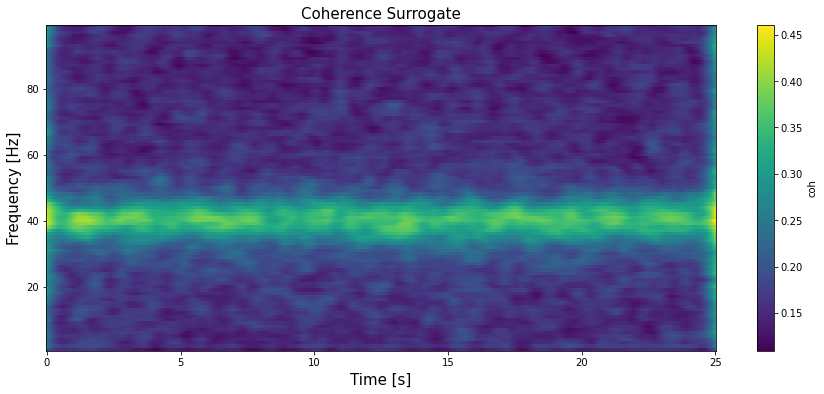

In [12]:
plt.figure(figsize=(15,6))
coh_surr.isel(roi=0, seeds=8).mean(dim="trials").plot.imshow(x="times", y="freqs")
plt.ylabel('Frequency [Hz]', fontsize=15)
plt.xlabel('Time [s]', fontsize=15)
plt.title('Coherence Surrogate', fontsize=15)

NameError: name 'count' is not defined

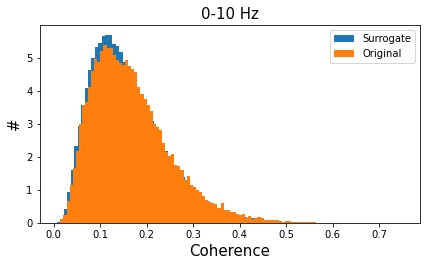

In [13]:
foi = [[0,10],[10,30],[30,50],[50,100]]
plt.figure(figsize=(15,8))
for i,f_c in enumerate(foi):
    plt.subplot(2,2,i+1)
    plt.hist(coh_surr.sel(freqs=slice(f_c[0],f_c[1])).mean(dim='freqs').values.flatten(), density=True,bins=100, label='Surrogate');
    plt.hist(coh.sel(freqs=slice(f_c[0],f_c[1])).mean(dim='freqs').values.flatten(), density=True,bins=100, label='Original');
    plt.ylabel('#', fontsize=15)
    plt.xlabel('Coherence', fontsize=15)
    plt.legend()
    plt.title(f'{f_c[0]}-{f_c[1]} Hz', fontsize=15)
    count += 1
plt.tight_layout()